# Business Case:


The business case is on inventory management. Keeping
Inventory of spares in various service centres to the market demand.
always a challenge, as most service centres spend a significant amount
in spare parts inventory costs. Despite this, the availability of spare
parts have been one of the problem areas.

# Project Goal:
Create a Predictive model for inventory forecasting so that
Service centre achieves JIT standards

## Contents
- [Import Libraries](#Import-Libraries)
- [Load Data](#Load-Data)
- [Basic EDA](#Basic-EDA)
- [Purchase and service Lead Time](#Purchase-and-service-Lead-Time)
- [Data Preprocessing](#Data-Preprocessing)
- [Advanced EDA](#Advanced-EDA)
- [Spare part demand trends, and seasonality](#Spare-part-demand-trends-and-seasonality)
- [Time Series Analysis](#Time-Series-Analysis)
- [Time Downsampling](#Time-Downsampling)
- [Moving Average rolling window](#Moving-Average-rolling-window)
- [Cumulative mean with expanding window](#Cumulative-mean-with-expanding-window)
- [Time Series Stationarity](#Time-Series-Stationarity)
- [1 Too Few Observations (Only 3)](#1-Too-Few-Observations-only-3)
- [2 High p-value (0.478808)](#2-High-p-value-0478808)
- [3 ADF test statistic > all critical values](#3-ADF-test-statistic--all-critical-values)
- [Differencing](#Differencing)
- [Time Series Forecasting](#Time-Series-Forecasting)
- [Forecasting with Holt's-Winter method](#Forecasting-With-Holts-Winter-method)
- [Evaluating train against test set](#Evaluating-train-against-test-set)
- [Plot Actual vs Predicted values](#Plot-Actual-vs-Predicted-values)
- [Evalution Metrics](#Evalution-Metrics)
- [Seasonal Autoregressive Integreted Moving Average(SARIMA)](#Seasonal-Autoregressive-Integreted-Moving-Averagesarima)
- [Error/Trend/Seasonality Decomposition](#Error/Trend/Seasonality-Decomposition)
- [Selecting SARIMA orders](#Selecting-sSARIMA-orders)
- [Fitting the model](#Fitting-the-model)
- [Plot the predictions](#Plot-the-predictions)
- [Model's Evaluation](#Models-Evaluation)
- [Forecast for next 10 weeks](#Forecast-for-next-10-weeks)
- [Induct exogenous variable in the SARIMAX model](#Induct-exogenous-variable-in-the-SARIMA-model)


# Import Libraries 

In [793]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from pmdarima import auto_arima 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
import matplotlib.dates as mdates
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [794]:
df = pd.read_csv("inventory.csv")

In [795]:
df.shape

(28482, 7)

In [796]:
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


# Basic EDA

In [797]:
df.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

In [798]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28482 entries, 0 to 28481
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   invoice_date           28482 non-null  object
 1   job_card_date          28482 non-null  object
 2   business_partner_name  28482 non-null  object
 3   vehicle_no             28482 non-null  object
 4   vehicle_model          28482 non-null  object
 5   current_km_reading     28482 non-null  int64 
 6   invoice_line_text      28448 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


Few null values are there in 'invoice_line_text'

In [799]:
df.isnull().sum()

invoice_date              0
job_card_date             0
business_partner_name     0
vehicle_no                0
vehicle_model             0
current_km_reading        0
invoice_line_text        34
dtype: int64

In [800]:
100*df.isnull().sum()/df.shape[0]

invoice_date             0.000000
job_card_date            0.000000
business_partner_name    0.000000
vehicle_no               0.000000
vehicle_model            0.000000
current_km_reading       0.000000
invoice_line_text        0.119374
dtype: float64

0.12% records of invoice_line_text are nulls => dropping those rows

In [801]:
df = df[pd.notnull(df.invoice_line_text)].reset_index(drop=True)
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [802]:
df.shape

(28448, 7)

# Purchase and service Lead Time

In [803]:
df['invoice_date'] = pd.to_datetime(df['invoice_date'], errors='coerce')
df['job_card_date'] = pd.to_datetime(df['job_card_date'], errors='coerce')
df['lead_time'] = (df['invoice_date'] - df['job_card_date']).dt.days
df['lead_time'] = df['lead_time'].apply(lambda x: x if x >= 0 else pd.NA)

print(df[['invoice_date', 'job_card_date', 'lead_time']].head(50))

   invoice_date job_card_date lead_time
0    2017-05-30    2017-05-30         0
1    2017-02-06    2017-05-31      <NA>
2    2017-02-06    2017-05-31      <NA>
3    2017-02-06    2017-05-31      <NA>
4    2017-02-06    2017-05-31      <NA>
5    2017-02-06    2017-05-31      <NA>
6    2017-02-06    2017-05-31      <NA>
7    2017-05-31    2017-05-31         0
8    2017-05-31    2017-05-31         0
9    2017-05-31    2017-05-31         0
10   2017-05-31    2017-05-31         0
11   2017-05-31    2017-05-31         0
12   2017-05-31    2017-05-31         0
13   2017-05-31    2017-05-31         0
14   2017-05-31    2017-05-31         0
15   2017-05-31    2017-05-31         0
16   2017-05-31    2017-05-31         0
17   2017-03-06    2017-05-31      <NA>
18   2017-03-06    2017-05-31      <NA>
19   2017-03-06    2017-05-31      <NA>
20   2017-03-06    2017-05-31      <NA>
21   2017-03-06    2017-05-31      <NA>
22   2017-03-06    2017-05-31      <NA>
23   2017-03-06    2017-05-31      <NA>


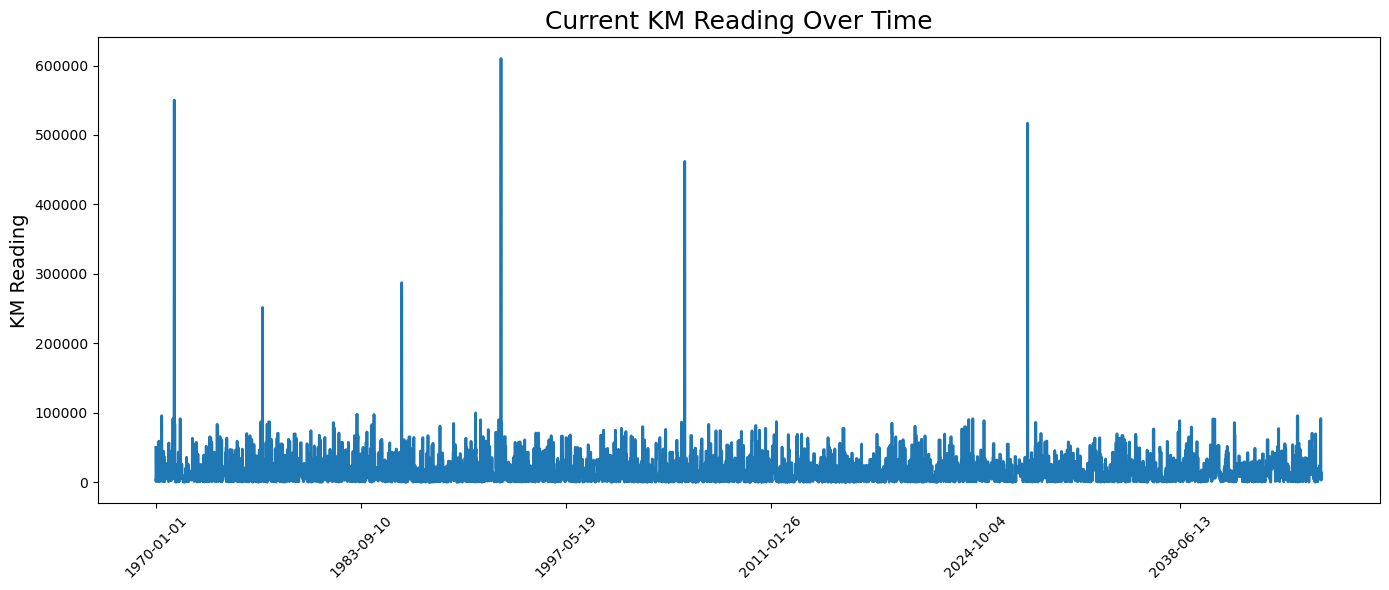

In [773]:
# Handling outliers
df['current_km_reading'] = pd.to_numeric(df['current_km_reading'], errors='coerce')

plt.figure(figsize=(14, 6))
ax = df['current_km_reading'].plot(kind='line', linewidth=2)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title('Current KM Reading Over Time', fontsize=18)
plt.ylabel('KM Reading', fontsize=14)
plt.tight_layout()
plt.show()


Note: Normally bikes can't exceed 100,000 km.

In [727]:
df[df.current_km_reading >100000].shape[0]

35

In [728]:
# removing outliers
df=df[df.current_km_reading <=100000].reset_index(drop=True)
df.shape

(28413, 7)

In [729]:
df.head()

,invoice_date,job_card_date,business_partner_name,vehicle_no,vehicle_model,current_km_reading,invoice_line_text
0,30-05-17,30-05-17,shivXXXXXXXXXX,KA03MFXXXX,BAJAJ AVENGER STREET 220,50000,ENGINE OIL
1,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,ENGINE OIL
2,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,POLISH
3,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,CONSUMABLES
4,02-06-17,31-05-17,KIRAXXXXXXXXXX,KA53ESXXXX,BAJAJ PULSAR NS 200,758,COOLANT OIL


In [730]:
df.columns

Index(['invoice_date', 'job_card_date', 'business_partner_name', 'vehicle_no',
       'vehicle_model', 'current_km_reading', 'invoice_line_text'],
      dtype='object')

In [731]:
# dropping redundant columns ['invoice_date','job_card_date',  'business_partner_name', 'vehicle_no']
df = df[['job_card_date', 'vehicle_model', 'invoice_line_text']]
df.shape

(28413, 3)

In [732]:
grouped_df = df.groupby(['vehicle_model'])['invoice_line_text'].count().reset_index()
grouped_df.rename(columns={'invoice_line_text': 'count'}, inplace=True)
grouped_df = grouped_df.sort_values(by='count', ascending=False)
grouped_df

,vehicle_model,count
12,BAJAJ PULSAR 150,8599
2,BAJAJ AVENGER STREET 220,4212
14,BAJAJ PULSAR 220,2654
13,BAJAJ PULSAR 180,2251
18,BAJAJ PULSAR NS 200,2203
5,BAJAJ CT 100,1432
7,BAJAJ DISCOVER 125,1345
0,BAJAJ AVENGER STREET,1111
11,BAJAJ PLATINA,843
23,BAJAJ V150,685


In [733]:
grouped_df = df.groupby(['invoice_line_text'])['vehicle_model'].count().reset_index()
grouped_df.rename(columns={'vehicle_model': 'count'}, inplace=True)
grouped_df = grouped_df.sort_values(by='count', ascending=False)
grouped_df

,invoice_line_text,count
148,ENGINE OIL,3799
76,CHAIN LUBRICATION,3437
209,GENERAL SERVICE,2136
10,AIR FILTER,1713
2,3M OIL,1628
...,...,...
7,8 SIZE BOLT,1
449,TAPPED WELDING,1
6,6303 BEARING,1
497,YOKE SET,1


In [734]:
df['invoice_line_text'].nunique()

502

In [735]:
# printing all items from invoice_line_text
for item in df.invoice_line_text.unique():
    print(f"'{item}',")

'ENGINE OIL',
'POLISH',
'CONSUMABLES',
'COOLANT OIL',
'CHAIN LUBRICATION',
'4 WAY SWITCH',
'3M OIL',
'GENERAL SERVICE',
'OIL FILTER',
'INDICATOR',
'HEAD REST',
'VALVE GUIDE',
'TIMMING CHAIN',
'FOOT REST',
'LOW BEAM BULB',
'VALVE GRAINDING',
'DISC PAD',
'LOADING GEAR',
'PACKING KIT',
'TIMMING CHAIN PAD',
'TENSIONER',
'CLUTCH BELL REST',
'CLUTCH ASSEMBLY',
'VALVE KIT',
'SPARK PLUG',
'ONE WAY CLUTCH',
'BORE KIT',
'AIR FILTER',
'HEAD RUBBER',
'CLUTCH CABLE',
'CRANK SHAFT',
'BRAKE ADJUSTMENT',
'BRAKE SHOE',
'AIR FILTER CHECKUP',
'DRUM BOLT WASHER',
'TANK CLEANING',
'FORK BEND',
'GEAR SHAFT',
'CLUTCH COVER GASKET',
'INDICATOR BULB',
'GEAR LEVER',
'HANDLEBAR',
'CRASH GUARD',
'FORK OIL SEAL',
'FORK OIL',
'SIDE SHIELD',
'VISIOR',
'FORK CONE SET',
'HEAD LIGHT DOOM',
'TANK ASSEMBLY',
'Clutch cable',
'DISC LEVER',
'CARBURETOR CLEANING',
'SEAT COVER',
'BUZZER',
'TAIL LAMP BULB',
'DISC OIL',
'DISC OVERHUAL',
'MASTER ASSEMBLY',
'CHAIN COVER RUBBER',
'ENGINE GUARD',
'CLUTCH CAM ',
'DOOM',
'WHEEL RUBBE

# Data Preprocessing

In [736]:
# data cleaning
df['invoice_line_text'] = df['invoice_line_text'].str.replace('BULB ', 'BULB')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('OVERHUAL', 'OVERHAUL')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('WIELDING', 'WELDING')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('ENGINE OIL TOPUP', 'ENGINE OIL')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('ASSEBLY', 'ASSEMBLY')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('GRIP HANDLE', 'HANDLE GRIPPER')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('HANDLEBAR', 'HANDLE BAR')
df['invoice_line_text'] = df['invoice_line_text'].str.replace('NUMBER PLATE WITH STICKERS', 'NUMBER PLATE')

In [737]:
service_related_tokens = [
'OVERHAUL', 
'WELDING',
'SERVICE', 
'WORK',
'PUNCHER',
'REBORE',
'DENT',
'RC CARD',
'TAX',
'ENGINE WORK',
'CHECK',
'LABOUR',
'CHARGE',
'FEES',
'PAYMENT',
'STICKERS'
'ADJUSTMENT',
'REGISTOR',
'INSURANCE',
'ADJUSTMENT',
'REMOVAL', 
'THREADING', 
'CLEANING',
]
services = []
for item in df.invoice_line_text.unique():
    try:
        if sum([item.find(token)!= -1 for token in service_related_tokens]) > 0:
            services.append(item)
    except:
        print(item)
        
need_to_be_removed_in_services = [
'PETROL',
'VALVE GRAINDING',
'CHAIN LUBRICATION',
'ENGINE RE CONDITION',
'HEAD LIGHT WIRING',
'EX SHOW ROOM'
]
services.extend(need_to_be_removed_in_services)

In [738]:
len(services)

67

In [739]:
for item in df.invoice_line_text.unique():
        if item not in services:
            print(item)

ENGINE OIL
POLISH
CONSUMABLES
COOLANT OIL
4 WAY SWITCH
3M OIL
OIL FILTER
INDICATOR
HEAD REST
VALVE GUIDE
TIMMING CHAIN
FOOT REST
LOW BEAM BULB
DISC PAD
LOADING GEAR
PACKING KIT
TIMMING CHAIN PAD
TENSIONER
CLUTCH BELL REST
CLUTCH ASSEMBLY
VALVE KIT
SPARK PLUG
ONE WAY CLUTCH
BORE KIT
AIR FILTER
HEAD RUBBER
CLUTCH CABLE
CRANK SHAFT
BRAKE SHOE
DRUM BOLT WASHER
FORK BEND
GEAR SHAFT
CLUTCH COVER GASKET
INDICATOR BULB
GEAR LEVER
HANDLE BAR
CRASH GUARD
FORK OIL SEAL
FORK OIL
SIDE SHIELD
VISIOR
FORK CONE SET
HEAD LIGHT DOOM
TANK ASSEMBLY
Clutch cable
DISC LEVER
SEAT COVER
BUZZER
TAIL LAMP BULB
DISC OIL
MASTER ASSEMBLY
CHAIN COVER RUBBER
ENGINE GUARD
CLUTCH CAM 
DOOM
WHEEL RUBBER
bore kit
ENGINE BEARING
CRANK RESET
CARBURETOR DIAPHRAGM RUBBER
CLUTCH LEVER
DRUM BOLT
LOCK SET
RIGHT SHIELD CAP
SWITCH
SHOCK ABSORBER
STEP HOLDER
ACCELATOR CABLE
JALL SCREW
TANK COVER
HANDLE LOCK
GRIPPER
PARKING BULB
WIND SHIELD
SPEEDOMETER CAP
HEAD LIGHT STAY
CONE SET
DOOM SCREW KIT
DISK PAD
HEAD LIGHT BULB
CALIPER AS

In [740]:
# dropping rows related to services
df = df[~df.invoice_line_text.isin(services)]
df = df.reset_index(drop=True)
df.shape

(21298, 3)

In [741]:
df.head()

,job_card_date,vehicle_model,invoice_line_text
0,30-05-17,BAJAJ AVENGER STREET 220,ENGINE OIL
1,31-05-17,BAJAJ PULSAR NS 200,ENGINE OIL
2,31-05-17,BAJAJ PULSAR NS 200,POLISH
3,31-05-17,BAJAJ PULSAR NS 200,CONSUMABLES
4,31-05-17,BAJAJ PULSAR NS 200,COOLANT OIL


In [742]:
# renaming some columns
df.rename(columns={"job_card_date":"date", "invoice_line_text":"spare_part"}, inplace=True)

In [743]:
# changing object to datetime datatype
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y')

In [744]:
df.head()

,date,vehicle_model,spare_part
0,2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
1,2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2,2017-05-31,BAJAJ PULSAR NS 200,POLISH
3,2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
4,2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL


#  Advanced EDA

In [745]:

# Calculate the counts of unique elements of invoice_line_text
value_counts = df['spare_part'].value_counts()
print(value_counts)

spare_part
ENGINE OIL                 3804
AIR FILTER                 1713
3M OIL                     1628
CONSUMABLES                1595
POLISH                     1245
                           ... 
ONE WAY CLUTCH ASSEMBLY       1
SPEEDOMETER FLOP              1
WIND SHIELD RUBBER KIT        1
MAGNET OIL SEAL               1
HELMET                        1
Name: count, Length: 431, dtype: int64


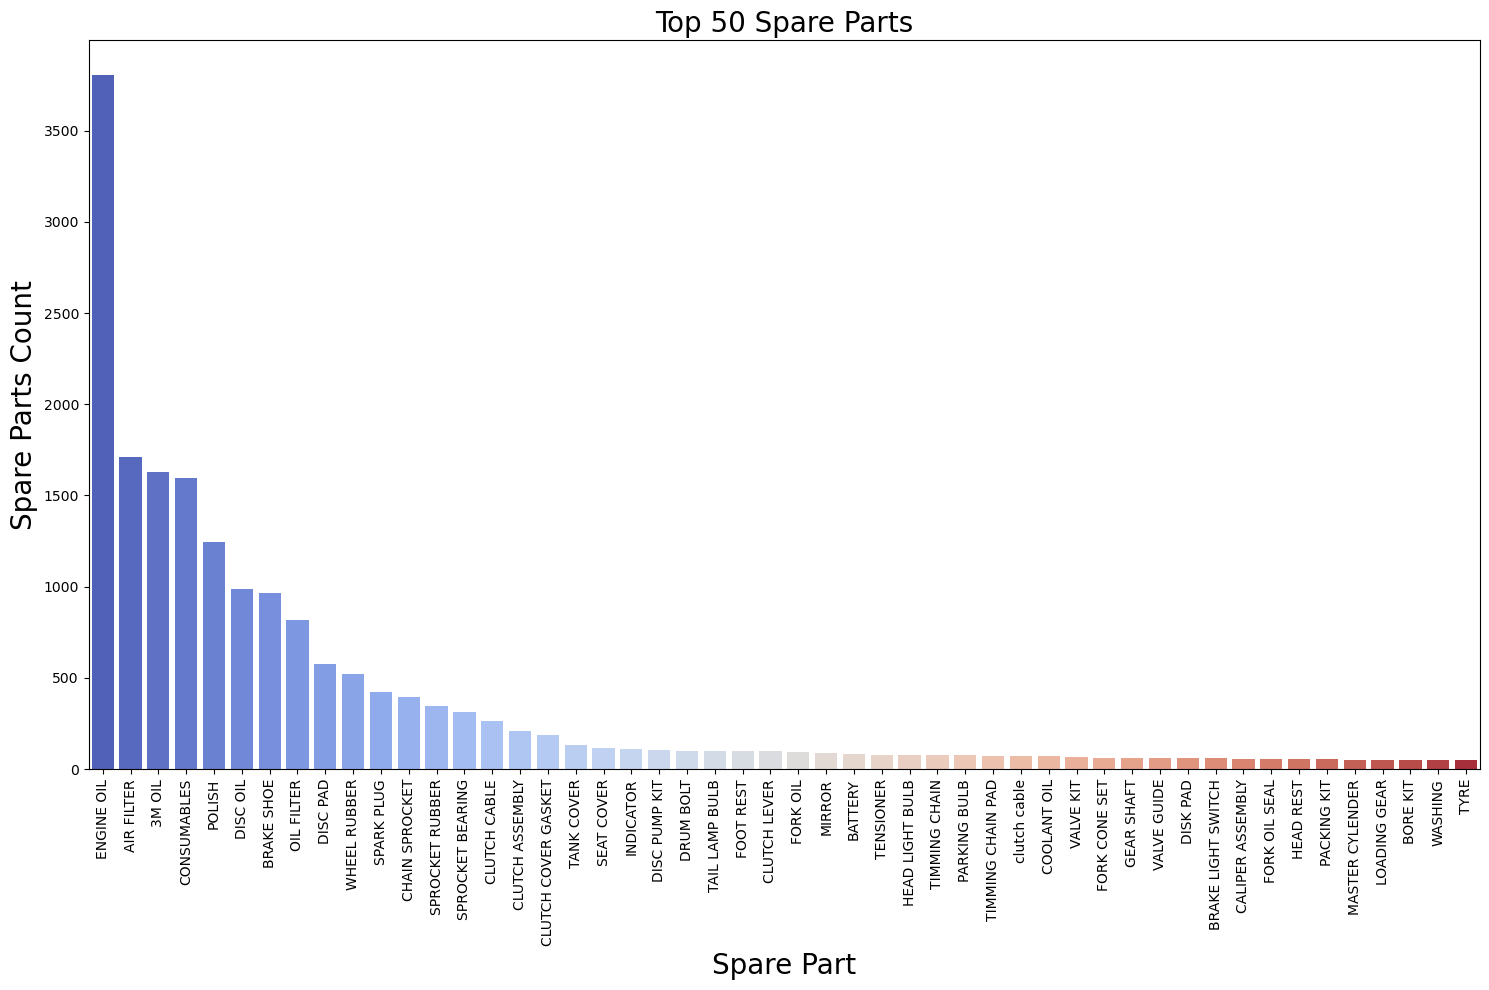

In [746]:
# Create a figure and axes
top_50_spare_parts = df['spare_part'].value_counts().index[:50]
colors = sns.color_palette("coolwarm", len(top_50_spare_parts))
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df,x='spare_part',order=top_50_spare_parts,ax=ax,palette=dict(zip(top_50_spare_parts, colors)))
ax.set_title('Top 50 Spare Parts', fontsize=20)
ax.set_ylabel('Spare Parts Count', fontsize=20)
ax.set_xlabel('Spare Part', fontsize=20)
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


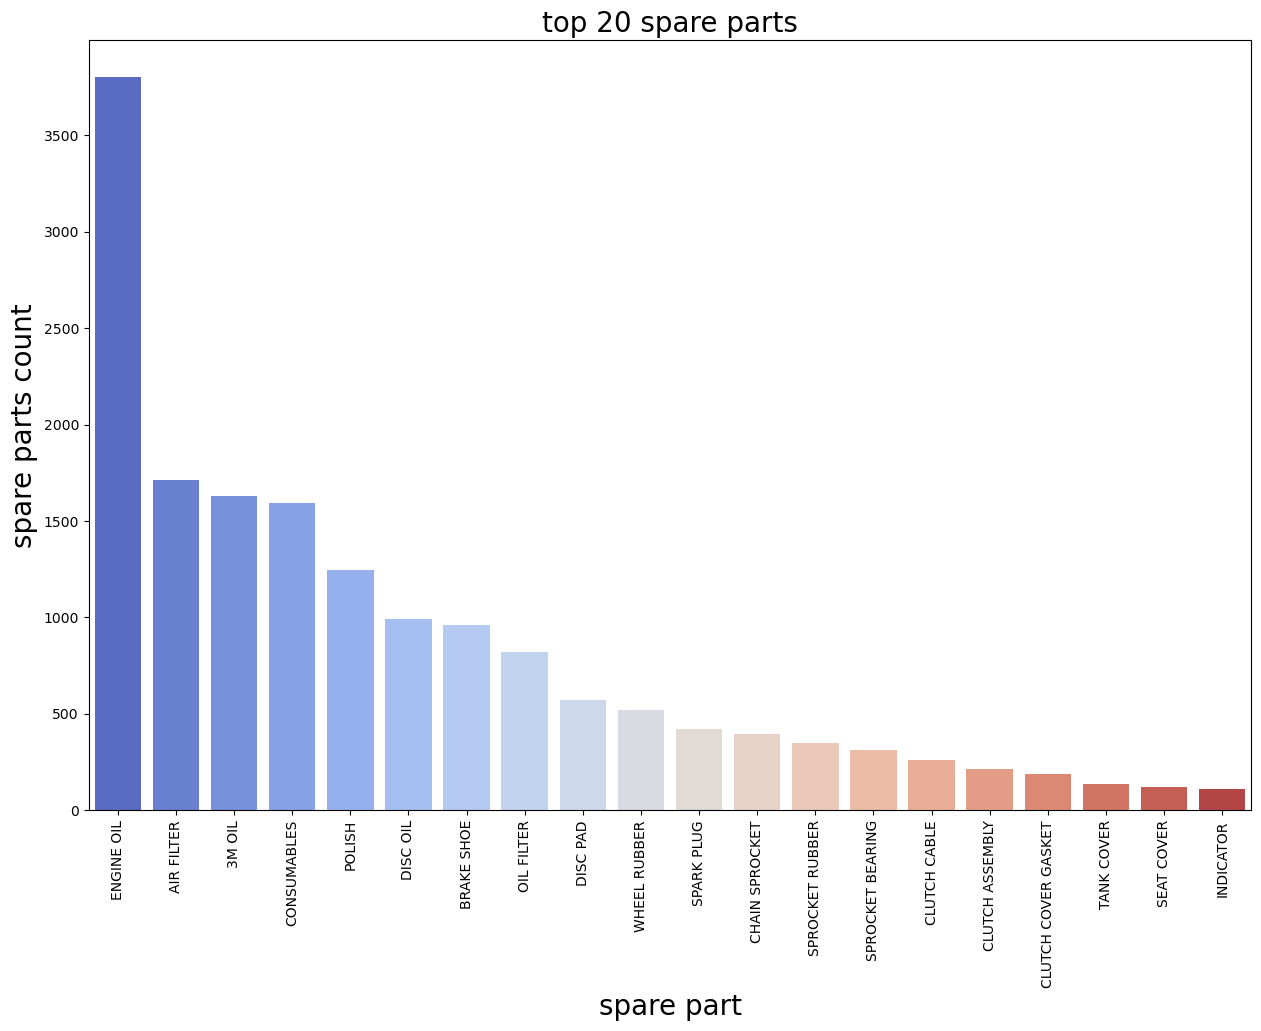

In [747]:
# Create a figure and axes
top_20_spare_parts = df['spare_part'].value_counts().index[:20]
colors = sns.color_palette("coolwarm", len(top_20_spare_parts))
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(data=df, x='spare_part',order=df['spare_part'].value_counts().index[:20],ax=ax,palette=dict(zip(top_20_spare_parts, colors)))
ax.set_title('top 20 spare parts', fontsize=20)
ax.set_ylabel('spare parts count', fontsize=20)
ax.set_xlabel('spare part', fontsize=20)
ax.tick_params(axis='x', rotation=90)
plt.show()

In [748]:
# grouping by vehicle_model

vm_grouped_df = df.groupby(['vehicle_model'])['spare_part'].count().reset_index()
vm_grouped_df.rename(columns={'spare_part': 'count'}, inplace=True)
vm_grouped_df = vm_grouped_df.sort_values(by='count', ascending=False)
vm_grouped_df

,vehicle_model,count
12,BAJAJ PULSAR 150,6480
2,BAJAJ AVENGER STREET 220,3058
14,BAJAJ PULSAR 220,1984
18,BAJAJ PULSAR NS 200,1705
13,BAJAJ PULSAR 180,1703
5,BAJAJ CT 100,1119
7,BAJAJ DISCOVER 125,1027
0,BAJAJ AVENGER STREET,767
11,BAJAJ PLATINA,661
23,BAJAJ V150,523


In [749]:
# grouping by spare part
sp_grouped_df = df.groupby(['spare_part'])['vehicle_model'].count().reset_index()
sp_grouped_df.rename(columns={'vehicle_model': 'count'}, inplace=True)
sp_grouped_df = sp_grouped_df.sort_values(by='count', ascending=False)
sp_grouped_df

,spare_part,count
127,ENGINE OIL,3804
9,AIR FILTER,1713
2,3M OIL,1628
90,CONSUMABLES,1595
298,POLISH,1245
...,...,...
426,YOKE SET,1
7,8 SIZE BOLT,1
6,6303 BEARING,1
5,6202 BEARING,1


In [750]:
df.date.nunique()

553

In [751]:
sp_grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 431 entries, 127 to 430
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   spare_part  431 non-null    object
 1   count       431 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


In [752]:
sp_grouped_df.shape[0]

431

In [753]:
sp_grouped_df[sp_grouped_df["count"]>1].shape[0]

288

In [754]:
sp_grouped_df[sp_grouped_df["count"]>10].shape[0]

128

In [755]:
sp_grouped_df[sp_grouped_df["count"]>=100].shape[0]

23

# Spare part demand trends, and seasonality

In [756]:
# setting date as index columns
df.set_index('date')
df_index.head()

,vehicle_model,spare_part
date,,
2017-05-30,BAJAJ AVENGER STREET 220,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,ENGINE OIL
2017-05-31,BAJAJ PULSAR NS 200,POLISH
2017-05-31,BAJAJ PULSAR NS 200,CONSUMABLES
2017-05-31,BAJAJ PULSAR NS 200,COOLANT OIL


In [757]:
daily_df_index = df.set_index('date', inplace=True)
daily_df_index = df['spare_part'].resample('D').sum()
daily_df_index.shape

(587,)

In [758]:
daily_df_index.head()

date
2017-05-30                                           ENGINE OIL
2017-05-31    ENGINE OILPOLISHCONSUMABLESCOOLANT OIL4 WAY SW...
2017-06-01    HEAD RUBBER3M OILBRAKE SHOEENGINE OILENGINE OI...
2017-06-02    ENGINE OILSEAT COVER3M OILOIL FILTERBUZZER3M O...
2017-06-03    Clutch cableENGINE OILDISC OILDISC OILMASTER A...
Freq: D, Name: spare_part, dtype: object

In [711]:
# resampling
weekly_df_index = df_index['spare_part'].resample('W').count()
weekly_df_index.shape

(84,)

In [712]:
weekly_df_index.head()

date
2017-06-04    116
2017-06-11    237
2017-06-18    252
2017-06-25    219
2017-07-02    197
Freq: W-SUN, Name: spare_part, dtype: int64

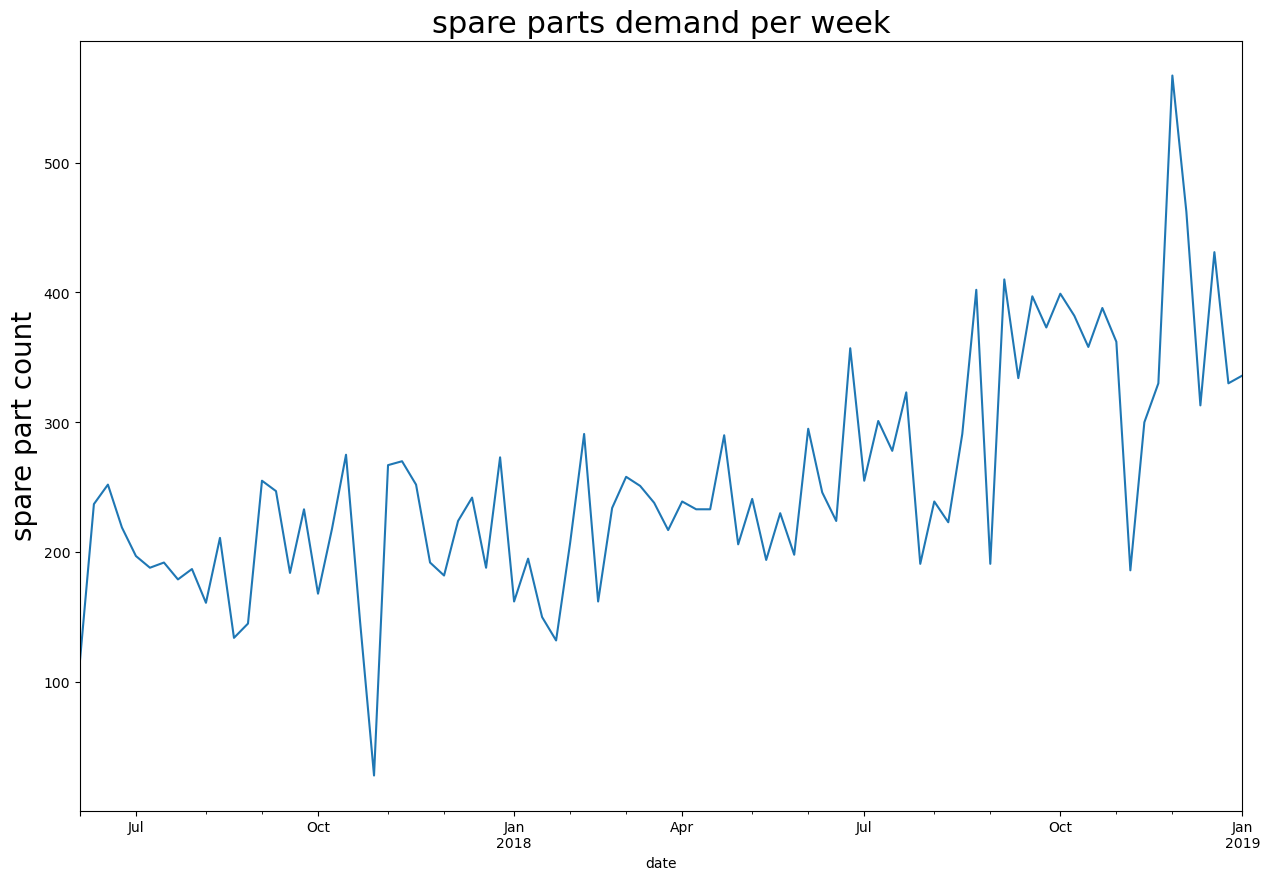

In [713]:
# Set the figure size
plt.figure(figsize=(15, 10))
weekly_df_index.plot()
plt.title('spare parts demand per week', fontsize=22)
plt.ylabel('spare part count', fontsize=20)
plt.show()

# Time Series Analysis

Analyzing the spare parts demand over time.

I will be exploring following statistical techniques over the above data to understand overall pattern and behaviour of the inventory data.

Time Downsampling
Moving Average with rolling window
Cummulative mean with expanding window
Exponential Weighted Moving Average
Time series stationarity

# Time Downsampling

In above steps, I resampled the data on weekly level. Now, let's see the demand of spare parts on monthly level.

In [714]:
monthly_df_index = weekly_df_index.resample('M').sum()
monthly_df_index.head()

date
2017-06-30    824
2017-07-31    943
2017-08-31    651
2017-09-30    919
2017-10-31    836
Freq: ME, Name: spare_part, dtype: int64

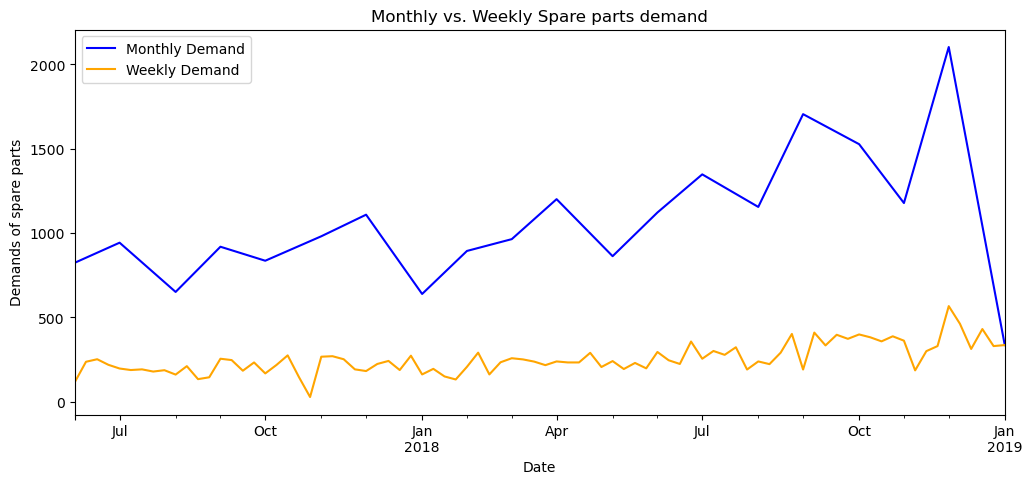

In [439]:
#plot the weekly demand and monthly demand on same view
fig, ax = plt.subplots(figsize=(12, 5))
monthly_df_index.plot(ax=ax, label='Monthly Demand', color='blue')
weekly_df_index.plot(ax=ax, label='Weekly Demand', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Demands of spare parts')
ax.set_title('Monthly vs. Weekly Spare parts demand')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

As seen in the grap above, weekly demand of spare part is higher then the monthly demand.

# Moving Average rolling window
Let's apply some smoothing techniques to understand overall behaviour the data.

In [440]:
weekly_df_df=weekly_df_index.to_frame()
weekly_df_df.columns

Index(['spare_part'], dtype='object')

In [441]:
#define window size of 4 weeks -> Monthly window

weekly_df_index = weekly_df_index.to_frame(name='spare_part')
window = 4
weekly_df_index['4W_MA'] = weekly_df_index['spare_part'].rolling(window=window).mean()


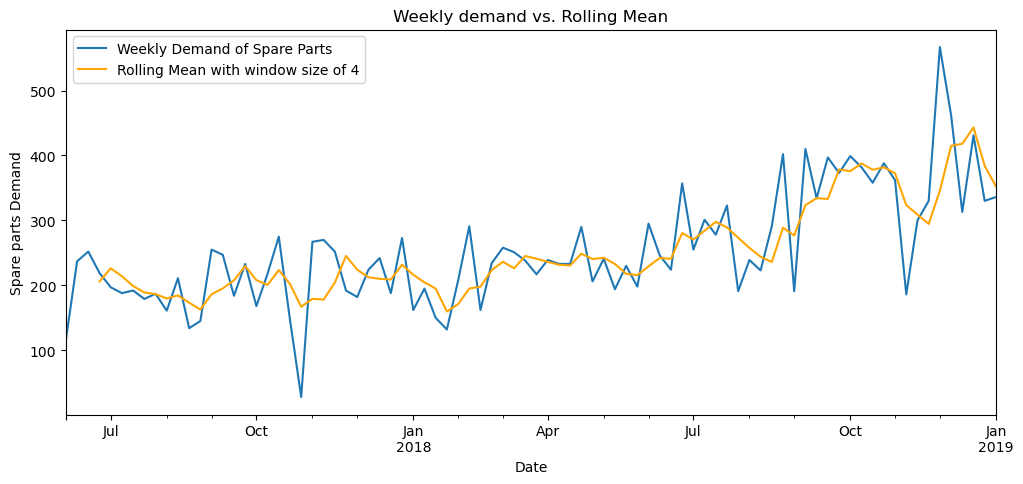

In [442]:
fig, ax = plt.subplots(figsize=(12, 5))
weekly_df_index['spare_part'].plot(ax=ax, label='Weekly Demand of Spare Parts')
weekly_df_index['4W_MA'].plot(ax=ax, label='Rolling Mean with window size of 4', color='orange')
ax.set_xlabel('Date')
ax.set_ylabel('Spare parts Demand')
ax.set_title('Weekly demand vs. Rolling Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

# Cumulative mean with expanding window
This can be helpful for understanding trends and pattern in the data over time.

In [443]:
#append cummulative mean over min period = 4 weeks
weekly_df_index['4W_CM'] = weekly_df_index['spare_part'].expanding(min_periods=4).mean()
weekly_df_index.head(10)

,spare_part,4W_MA,4W_CM
date,,,
2017-06-04,116,NaN,NaN
2017-06-11,237,NaN,NaN
2017-06-18,252,NaN,NaN
2017-06-25,219,206.00,206.000000
2017-07-02,197,226.25,204.200000
2017-07-09,188,214.00,201.500000
2017-07-16,192,199.00,200.142857
2017-07-23,179,189.00,197.500000
2017-07-30,187,186.50,196.333333


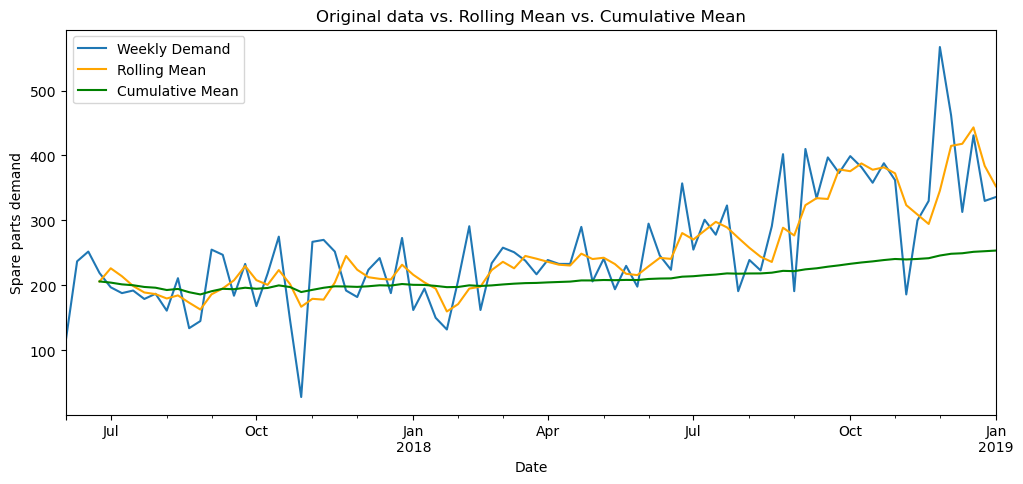

In [444]:
#plot the final df
fig, ax = plt.subplots(figsize=(12, 5))
weekly_df_index['spare_part'].plot(ax=ax, label='Weekly Demand')
weekly_df_index['4W_MA'].plot(ax=ax, label='Rolling Mean', color='orange')
weekly_df_index['4W_CM'].plot(ax=ax, label='Cumulative Mean', color='green')
ax.set_xlabel('Date')
ax.set_ylabel('Spare parts demand')
ax.set_title('Original data vs. Rolling Mean vs. Cumulative Mean')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')
plt.show()

As per this dataset, Cumulative means seems unstationary over time. 

# Time Series Stationarity
A time series is stationary if the mean and variance are fixed between two equidistance points.

Most the models like ARIMA and it's submodels need the stationary time series data.

Let's check if our data has some trend/seasonality or it is stationary. For stationarity check we can conduct augmented dickey fuller test.

In [445]:
dftest = adfuller(weekly_df_index['spare_part'], autolag='AIC')
dfout = pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# lags used','# observations'])
for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

ADF test statistic      -1.173080
p-value                  0.685068
# lags used              4.000000
# observations          79.000000
critical value (1%)     -3.515977
critical value (5%)     -2.898886
critical value (10%)    -2.586694
dtype: float64


# 1 Too Few Observations (Only 3)
The number of observations used is 3, which is far too small for a valid Augmented Dickey-Fuller test.

ADF requires at least 30–50 data points (more is better) to make any reliable conclusion about stationarity.

With just 3 observations, statistical tests like ADF become meaningless and unstable.

# 2 High p-value (0.478808)
The p-value is well above 0.05 → you fail to reject the null hypothesis.

This indicates the series is non-stationary, but since you only have 3 data points, this result is unreliable.

# 3 ADF test statistic > all critical values
ADF statistic -1.609524 is greater (i.e., less negative) than all critical values.

This also supports failing to reject the null hypothesis — but again, with 3 data points, it's not trustworthy.

Here we have a very high p-value at 0.68, which provides weak evidence against the null hypothesis, and so we fail to reject the null hypothesis, and decide that our dataset is not stationary.

# Differencing
Let's trying to make the series stationary

We can use first order of differencing to make it stationary.

In [198]:
weekly_df_index['spare_part_diff'] = diff(weekly_df_index['spare_part'], k_diff=1)

weekly_df_index.head(5)

,spare_part,4W_MA,4W_CM,spare_part_diff
date,,,,
2017-06-04,116,NaN,NaN,NaN
2017-06-11,237,NaN,NaN,121.0
2017-06-18,252,NaN,NaN,15.0
2017-06-25,219,206.00,206.0,-33.0
2017-07-02,197,226.25,204.2,-22.0


In [199]:
weekly_df_index = weekly_df_index[['spare_part', 'spare_part_diff']]
weekly_df_index.head()

,spare_part,spare_part_diff
date,,
2017-06-04,116,NaN
2017-06-11,237,121.0
2017-06-18,252,15.0
2017-06-25,219,-33.0
2017-07-02,197,-22.0


In [200]:
weekly_df_index['spare_part_diff'].plot(title="First order differencing")

<Axes: title={'center': 'First order differencing'}, xlabel='date'>

Now, let check for stationarity.

In [201]:
#drop first NaN entry
weekly_df_index = weekly_df_index.dropna()

In [202]:
print('Weekly spare diff')
dftest = adfuller(weekly_df_index['spare_part_diff'], autolag='AIC')

#covert into dataframe
dfout = pd.Series(dftest[0:4], index=['ADF test statistic','p-value','# lags used','# observations'])


for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Weekly spare diff
ADF test statistic     -7.704757e+00
p-value                 1.310568e-11
# lags used             3.000000e+00
# observations          7.900000e+01
critical value (1%)    -3.515977e+00
critical value (5%)    -2.898886e+00
critical value (10%)   -2.586694e+00
dtype: float64


After first order differencing, the series seems now stationarity. The resultant series has p-value less than 5%.

# Time Series Forecasting
Since we are done with Analysis of our data. We also checked for stationarity and then we introduced first order differencing to make the time series stationary.

We can now move ahead for modeling and forecasting for future dates.

We have a lot of options while doing model selection like we can use Auto Regression(AR), Autoregressive Moving Average(ARMA) or Autoregressive Integreted Moving Average(ARIMA).

For this project, let use Triple Exponential Smoothing for setting the base line and the SARIMA model to get better result.

Train/Test Split
For evaluating the model's performance it is crucial to evaluate it on unseen data. We can divide our data into train and test part. We can use train part for model's tranining and test part for model evaluation.

I am dividing the whole data into test and train such that test data has last 16 weeks points i.e last 2 months.

In [203]:
X = weekly_df_index
split_point = 16
train_data = X[:-split_point]
test_data = X[-split_point:]
print('Train data length:', len(train_data))
print('Test data length:', len(test_data))

Train data length: 67
Test data length: 16


# Forecasting with Holt's-Winter method
This method is another name for  Triple Exponential Smoothing. It takes seasonality into account. When we expect regular fluctuations in the future, this model attempts to map the seasonal behavior.

# Fitting the model

In [204]:
fitted_model = ExponentialSmoothing(train_data['spare_part'], trend='mul', seasonal='add', seasonal_periods=26).fit()

# Evaluating train against test set

In [205]:
test_predictions = fitted_model.forecast(len(test_data))
test_predictions

2018-09-23    298.511138
2018-09-30    272.491601
2018-10-07    298.633683
2018-10-14    332.060006
2018-10-21    285.960396
2018-10-28    182.033217
2018-11-04    331.658357
2018-11-11    313.905509
2018-11-18    321.014708
2018-11-25    274.504371
2018-12-02    312.111748
2018-12-09    328.639323
2018-12-16    333.935653
2018-12-23    354.409477
2018-12-30    331.705256
2019-01-06    317.479541
Freq: W-SUN, dtype: float64

In [206]:
train_data['spare_part'].plot(legend=True, label='TRAIN DATA')
test_data['spare_part'].plot(legend=True, label='TEST DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)

# Plot Actual vs Predicted values

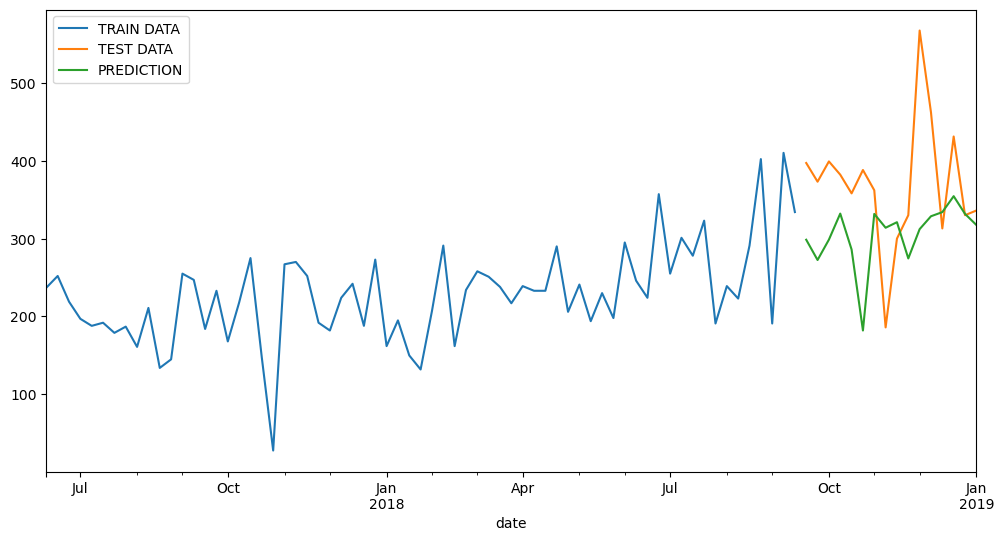

In [804]:
train_data['spare_part'].plot(legend=True, label='TRAIN DATA')
test_data['spare_part'].plot(legend=True, label='TEST DATA', figsize=(12, 6)).autoscale(axis='x', tight=True)
test_predictions.plot(legend=True, label='PREDICTION')
plt.show()

# Evalution Metrics
Since this is a type of regression problem we can use regression metrics like Mean Squared Error(MSE) or Root Mean Squared Error(RMSE) or Mean Absolute Error(MAE)

In [208]:
mae_error = mean_absolute_error(test_data['spare_part'], test_predictions)

print(f"Mean absolute error of the above model is {mae_error}")

Mean absolute error of the above model is 85.50426669508586


In [209]:
mse_error = mean_squared_error(test_data['spare_part'], test_predictions)

print(f"Mean squared error of the above model is {mse_error}")

Mean squared error of the above model is 11886.665525945325


# Seasonal Autoregressive Integreted Moving Average(SARIMA)

It's an extension of the ARIMA model that includes additional components to capture seasonality in time series data. SARIMA models are particularly useful for analyzing and forecasting data with recurring patterns that repeat over fixed intervals.

SARIMA models build upon the concepts of ARIMA models, with the addition of seasonal components:

Seasonal AutoRegressive (SAR) Component: This component captures the relationship between the current value and past values at the same seasonal lag. It's similar to the AR component but operates over the seasonal interval.

Seasonal Integrated (SI) Component: Just like the non-seasonal integrated component in ARIMA, this component accounts for differencing the series at the seasonal interval to achieve seasonal stationarity.

Seasonal Moving Average (SMA) Component: This component captures the relationship between the current value and past error terms at the same seasonal lag. It's similar to the MA component but operates over the seasonal interval.

A SARIMA(p, d, q) × (P, D, Q, s) model is defined by these components:

 .p is the order of the non-seasonal AutoRegressive (AR) component.
 .d is the degree of non-seasonal differencing.
 .q is the order of the non-seasonal Moving Average (MA) component.
 .P is the order of the seasonal AutoRegressive (SAR) component.
 .D is the degree of seasonal differencing.
 .Q is the order of the seasonal Moving Average (SMA) component.
 .s is the number of time steps in each seasonal period.

# Error/Trend/Seasonality Decomposition

In [210]:
result = seasonal_decompose(weekly_df_index['spare_part'], model='mul', period=4)
result.plot();

Let take a look at the amplitude of sesonality

In [211]:
max(result.seasonal), min(result.seasonal)

(1.0707335507260987, 0.898151724320523)

The apmplitude of the sesonality curve seems too low, so we can ignore the sesonality in the time series.

# Selecting SARIMA orders
For getting optimal values of SARIMA orders i.e (p, d, q)X(P, D, Q) we can use heuristic search. or we can also use some third party library for it.

In [212]:
auto_arima(train_data['spare_part'], seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   67
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                -357.922
Date:                             Wed, 30 Jul 2025   AIC                            733.844
Time:                                     17:44:10   BIC                            753.551
Sample:                                 06-11-2017   HQIC                           741.631
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.3686      1.158      1.182      0.237      -0.901       3.638
ar.L1         -0.0587      0.165     -0.357      0.721      -0.381       0.264
ar.L2         -0.0972      0.173     -0.562      0.574      -0.437       0.242
ar.L3          0.0511      0.174      0.294      0.769      -0.290       0.392
ar.L4         -0.0515      0.179     -0.289      0.773      -0.401       0.298
ar.L5          0.0535      0.179      0.298      0.766      -0.298       0.405
ma.L1         -0.9877      0.302     -3.273      0.001      -1.579      -0.396
ar.S.L12       0.2164      0.165      1.312      0.190      -0.107       0.540
sigma2      2848.4013    728.311      3.911      0.000    1420.939    4275.864
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.77
Prob(Q):                              0.87   Prob(JB):                         0.15
Heteroskedasticity (H):               1.22   Skew:                             0.04
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We need to know which combination leads to the minimum AIC score. Based on this score, we can decide the final order of our model.

# Fitting the model

In [213]:
model = SARIMAX(train_data['spare_part'],order=(5,1,1), seasonal_order=(1, 0, 0, 12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          spare_part   No. Observations:                   67
Model:             SARIMAX(5, 1, 1)x(1, 0, [], 12)   Log Likelihood                -359.625
Date:                             Wed, 30 Jul 2025   AIC                            735.250
Time:                                     17:44:11   BIC                            752.767
Sample:                                 06-11-2017   HQIC                           742.172
                                      - 09-16-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1307      0.261     -0.502      0.616      -0.641       0.380
ar.L2         -0.1479      0.241     -0.613      0.540      -0.621       0.325
ar.L3          0.0067      0.247      0.027      0.978      -0.477       0.491
ar.L4         -0.0720      0.212     -0.340      0.734      -0.487       0.343
ar.L5          0.0415      0.223      0.186      0.853      -0.396       0.479
ma.L1         -0.8333      0.214     -3.902      0.000      -1.252      -0.415
ar.S.L12       0.2224      0.179      1.240      0.215      -0.129       0.574
sigma2      3060.7657    521.074      5.874      0.000    2039.480    4082.051
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.86   Prob(JB):                         0.63
Heteroskedasticity (H):               1.33   Skew:                            -0.03
Prob(H) (two-sided):                  0.51   Kurtosis:                         3.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [214]:
# Obtain predicted values
start=len(train_data)
end=len(train_data)+len(test_data)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels')

In [215]:
# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test_data['spare_part'][i]}")

predicted=266.388467 , expected=397
predicted=317.7097214, expected=373
predicted=288.7464433, expected=399
predicted=312.3835184, expected=382
predicted=283.8946753, expected=358
predicted=287.4628656, expected=388
predicted=288.2153936, expected=362
predicted=301.8649572, expected=186
predicted=326.5662752, expected=300
predicted=280.4248042, expected=330
predicted=328.4191544, expected=567
predicted=311.7755702, expected=462
predicted=296.7515572, expected=313
predicted=308.0652507, expected=431
predicted=301.7201939, expected=330
predicted=306.9318002, expected=336


# Plot the predictions

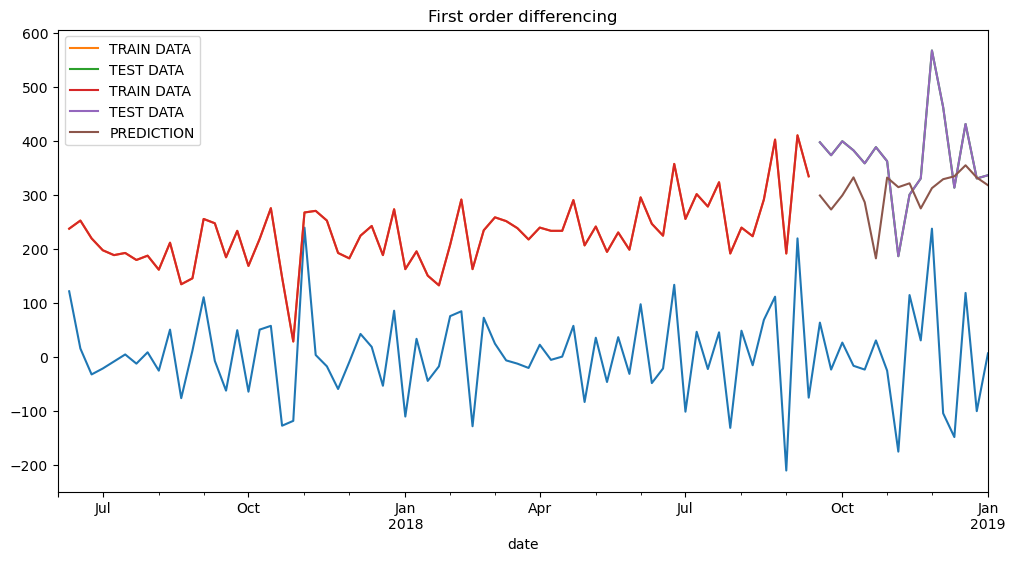

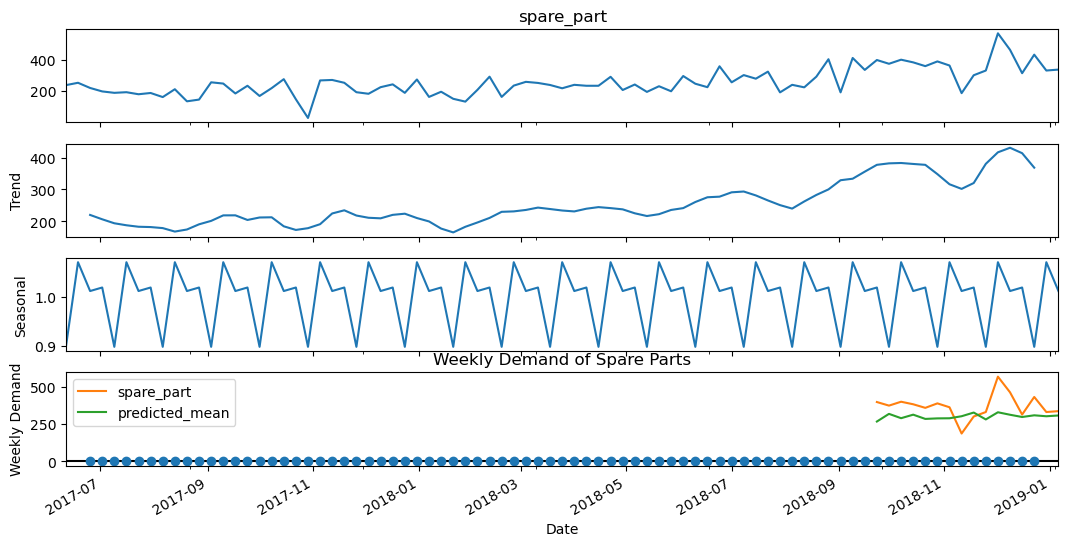

In [216]:
# Plot predictions against known values
title = 'Weekly Demand of Spare Parts'
ylabel='Weekly Demand'
xlabel='Date'
ax = test_data['spare_part'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

# Model's Evaluation
To evaluate the model's performance, let's see how the model is performing on the test set that we split out from the whole dataset.
We can forecast for test points, and then we can plot the actual test points and compare the model predictions visually and using some regression metrics.

In [217]:
error = mean_squared_error(test_data['spare_part'], predictions)
print(f'SARIMA(2,0,1,12) MSE Error: {error:11.10}')

SARIMA(2,0,1,12) MSE Error: 10703.76238


# Forecast for next 10 weeks
So far, we have split the dataset into a train and a test dataset. We fitted our SARIMA model over the training data and evaluated the performance on the test data.
Now we can use the same strategy to forecast future points. We can train the model on all data and then forecast the values for future points.

In [219]:
model = SARIMAX(weekly_df_index['spare_part'],order=(5,1,1), seasonal_order=(1, 0, 0, 12))
results = model.fit()
fcast = results.predict(len(weekly_df_index),len(weekly_df_index)+9,typ='levels').rename('SARIMA(5,1,1)(1,0,0,12) Forecast')
fcast


2019-01-13    381.667914
2019-01-20    384.623161
2019-01-27    382.791177
2019-02-03    335.441558
2019-02-10    356.941616
2019-02-17    365.812580
2019-02-24    418.313654
2019-03-03    396.338353
2019-03-10    363.549787
2019-03-17    388.715753
Freq: W-SUN, Name: SARIMA(5,1,1)(1,0,0,12) Forecast, dtype: float64

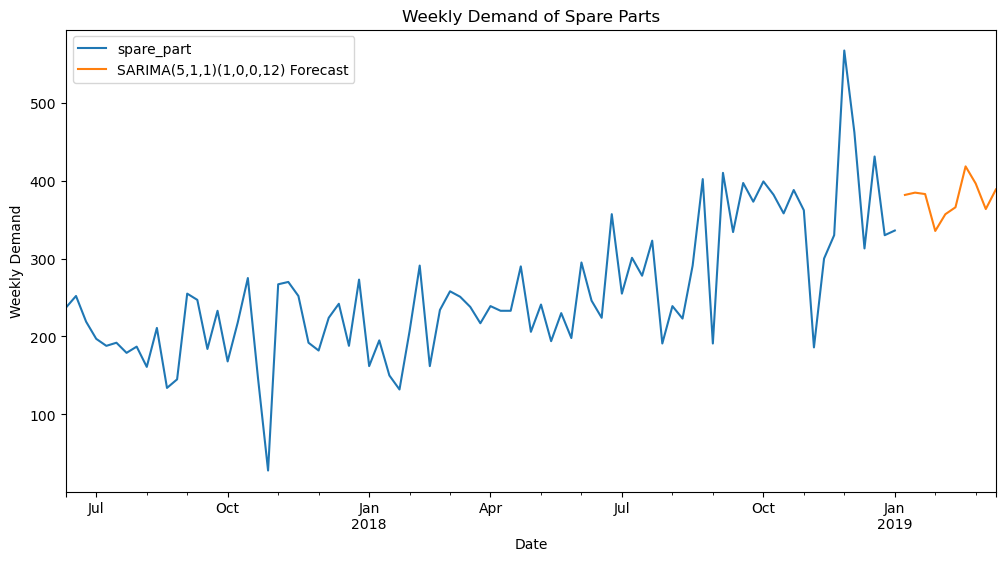

In [220]:
# Plot predictions against known values
title = 'Weekly Demand of Spare Parts'
ylabel='Weekly Demand'
xlabel='Date'
ax = weekly_df_index['spare_part'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

So far, we have analyzed the data in an univariate fashion, as we aggregated the spare parts count from the inventory data irrespective of the two-wheeler models.
We assumed the count of spare parts required for each model would be the same, and it does not depend on the model of the bike.
Let's explore the multivariate analysis where we also induct the two wheelers model into account.

# Induct exogenous variable in the SARIMAX model
Transform the dataset such that for each date, we have a distinct number of bikes and the spare parts count. It seems that if you have more bikes, you will need to have more spare parts count.

In [221]:
# grouping by vehicle_model

vm_grouped_df = df.groupby(['date','vehicle_model'])['spare_part'].count().reset_index()
vm_grouped_df.rename(columns={'spare_part': 'count'}, inplace=True)
vm_grouped_df = vm_grouped_df.sort_values(by='count', ascending=False).set_index('date')
vm_grouped_df

,vehicle_model,count
date,,
2018-11-30,BAJAJ PULSAR 150,61
2018-09-17,BAJAJ PULSAR 150,56
2017-10-12,BAJAJ PULSAR 150,49
2018-10-27,BAJAJ PULSAR 150,48
2017-07-08,BAJAJ PULSAR 150,48
...,...,...
2017-07-04,BAJAJ PULSAR LS135,1
2018-03-31,BAJAJ PULSAR 180,1
2017-06-10,BAJAJ V,1


In [222]:
vm_grouped_df = vm_grouped_df['count'].resample('W').sum()
vm_grouped_df.head()

date
2017-06-04    116
2017-06-11    237
2017-06-18    252
2017-06-25    219
2017-07-02    197
Freq: W-SUN, Name: count, dtype: int64

In [223]:
model = SARIMAX(train_data['spare_part'],exog=train_data[['spare_part_diff']],order=(1,2,1),seasonal_order=(1,2,2,7),enforce_invertibility=False)

results = model.fit()
last_diff_value = train_data['spare_part_diff'].iloc[-1]
exog_forecast = pd.DataFrame({'spare_part_diff': [last_diff_value]*n_steps})

fcast = results.predict(start=len(train_data), end=len(train_data) + n_steps - 1, exog=exog_forecast)
fcast.name = 'SARIMAX(1,2,1)(1,2,2,7) Forecast'
fcast

2018-09-23      360.879217
2018-09-30      513.340716
2018-10-07      632.902846
2018-10-14      814.067722
2018-10-21      830.472888
2018-10-28      884.022059
2018-11-04     1012.291617
2018-11-11     1136.428830
2018-11-18     1358.837241
2018-11-25     1591.010088
2018-12-02     1983.540100
2018-12-09     2043.914381
2018-12-16     2190.517825
2018-12-23     2525.197977
2018-12-30     2816.167033
2019-01-06     3265.814369
2019-01-13     3688.792926
2019-01-20     4277.827191
2019-01-27     4498.698647
2019-02-03     4793.958060
2019-02-10     5292.490574
2019-02-17     5781.771024
2019-02-24     6409.040187
2019-03-03     7046.333635
2019-03-10     7941.412767
2019-03-17     8310.851135
2019-03-24     8799.163511
2019-03-31     9596.695580
2019-04-07    10350.985672
2019-04-14    11297.549874
2019-04-21    12223.225178
2019-04-28    13418.878902
2019-05-05    14043.715399
2019-05-12    14779.836632
2019-05-19    15847.224350
2019-05-26    16900.662163
2019-06-02    18131.344102
2